In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import get_user_item_pairs, data_split
from optimization import tunning_number_iterations, k_cross_validation
import model as md

In [2]:
# Read Data and store on dataframes
movie_database = pd.read_csv('Small_Data/movies.csv')
users_ratings = pd.read_csv('Small_Data/ratings.csv')
tags_database = pd.read_csv('Small_Data/tags.csv')
links_database = pd.read_csv('Small_Data/links.csv')

In [3]:
# Display the first 10 items from the movies data set
movie_database[0:10]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [4]:
# Display the first 5 items from the rating data set
users_ratings[0:5]

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Shift users and movies ID by 1, so start at 0
users_ratings['userId'] = users_ratings['userId'] - 1
users_ratings['movieId'] = users_ratings['movieId'] - 1
movie_database['movieId'] = movie_database['movieId'] - 1

In [6]:
# Print ratings statistics describing numeric features
users_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,325.127564,19434.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,0.000000,0.000000,0.500000,8.281246e+08
25%,176.000000,1198.000000,3.000000,1.019124e+09
50%,324.000000,2990.000000,3.500000,1.186087e+09
75%,476.000000,8121.000000,4.000000,1.435994e+09
max,609.000000,193608.000000,5.000000,1.537799e+09


In [7]:
# Construct the data set based on the index of user, movies bind with the respective rating
# Build the list of usersIds
# Build the list of movieIds
(user_item_rating, list_userId, list_movieId)  = get_user_item_pairs(movie_database,users_ratings)

In [8]:
# Split the data in train, validation and test set
# Get the 10% for test set
# Break the rest for 25% validation and 75% train
(train_data,val_data,test_data) = data_split(user_item_rating)

In [9]:
# Perform tunning on the number of iterations for 10 experiments
# In each experiment increment the number of iterations from: 10, 20, until 100 iterations
# Save best model and collect the minimun validation for each experiment
best_model, validation_table = tunning_number_iterations(train_data,val_data,list_userId,list_movieId,10)

Number Training Iterations: 10 - Validation Loss: 0.1273338
Number Training Iterations: 20 - Validation Loss: 0.0522032
Number Training Iterations: 30 - Validation Loss: 0.0507265
Number Training Iterations: 40 - Validation Loss: 0.0506947
Number Training Iterations: 50 - Validation Loss: 0.0507062
Number Training Iterations: 60 - Validation Loss: 0.0507046
Number Training Iterations: 70 - Validation Loss: 0.0507048
Number Training Iterations: 80 - Validation Loss: 0.0507087
Number Training Iterations: 90 - Validation Loss: 0.0507009
Number Training Iterations: 100 - Validation Loss: 0.0506942


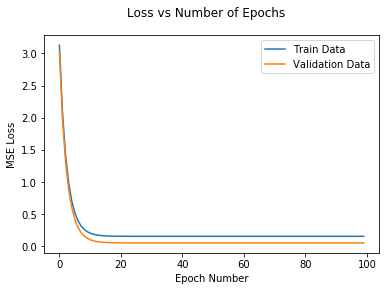

In [10]:
# Display the loss of the best model
best_model.plot_loss()

In [11]:
# Display the Validation Loss of each experiment
# Highligh the experiment with smallest validation loss
display(validation_table.style.highlight_min('Validation Loss').hide_index())

Number Iterations,Validation Loss
10,0.127334
20,0.052203
30,0.050727
40,0.050695
50,0.050706
60,0.050705
70,0.050705
80,0.050709
90,0.050701
100,0.050694


In [12]:
# Calculate and display the test loss and the norm of the feedback matrix of the best model
test_loss =  best_model.calculate_test_loss(test_data)
norm = best_model.calculate_norm()
test_norm_dict = {'Test Loss': [test_loss],'Norm':[norm]}
display(pd.DataFrame.from_dict(test_norm_dict).style.hide_index())

Test Loss,Norm
0.022638,19.495874


In [ ]:
# Keep the last hyper parameter tune as constant for the rest of experiments
# Number iterations = 70, smallest validation loss

In [23]:
def tunning_learning_rate(train_data,val_data,list_userId,list_movieId):
    tune_learning_rate_list = np.array([0.0001,0.0003,0.0007, 0.00001, 0.00003, 0.00007 , 0.000001],dtype=np.float64)
    validation_loss_list = []
    models = []
    for i in range(len(tune_learning_rate_list)):
        alpha = tune_learning_rate_list[i]
        model = md.CF_Model(list_userId,list_movieId)
        model.build_model(num_features=5,std=1)
        model.train(train_data,val_data,num_iter=50,learning_rate=alpha,regulator=0.001)
        min_validation = model.update_best_model()
        validation_loss_list.append(min_validation)
        models.append(model)
        print("Learning Rate: " + str(alpha) + " - Validation Loss: " + str(round(min_validation,7)))
    
    min_validation_idx = np.argmin(validation_loss_list)
    best_model = models[min_validation_idx]
    
    validation_dic = {'Learning Rate':tune_learning_rate_list, \
        'Validation Loss': validation_loss_list}
    val_table = pd.DataFrame.from_dict(validation_dic)

    return (best_model,val_table)

In [24]:
best_model, validation_table =  tunning_learning_rate(train_data,val_data,list_userId,list_movieId)

Learning Rate: 0.0001 - Validation Loss: 0.0512685
Learning Rate: 1e-05 - Validation Loss: 0.0512959
Learning Rate: 3e-05 - Validation Loss: 0.0512703
Learning Rate: 7e-05 - Validation Loss: 0.0512648
Learning Rate: 1e-06 - Validation Loss: 1.5759571


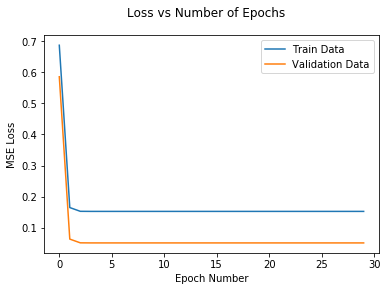

In [25]:
best_model.plot_loss()

In [26]:
# Display the Validation Loss of each experiment
# Highligh the experiment with smallest validation loss
display(validation_table.style.highlight_min('Validation Loss').hide_index())

Learning Rate,Validation Loss
0.000100,0.051269
0.000010,0.051296
0.000030,0.051270
0.000070,0.051265
0.000001,1.575957


In [27]:
model = md.CF_Model(list_userId, list_movieId)

In [410]:
model.build_model(num_features=5,std=1)

In [411]:
model.train(train_data,val_data,num_iter=40,learning_rate=0.00001,regulator=0.001)

i: 0 Train Loss: 3.3033 - Validation Loss: 3.2009
i: 1 Train Loss: 2.1846 - Validation Loss: 2.0825
i: 2 Train Loss: 1.4802 - Validation Loss: 1.3782
i: 3 Train Loss: 1.0273 - Validation Loss: 0.9254
i: 4 Train Loss: 0.7321 - Validation Loss: 0.6303
i: 5 Train Loss: 0.5379 - Validation Loss: 0.4361
i: 6 Train Loss: 0.4094 - Validation Loss: 0.3077
i: 7 Train Loss: 0.324 - Validation Loss: 0.2224
i: 8 Train Loss: 0.2672 - Validation Loss: 0.1656
i: 9 Train Loss: 0.2292 - Validation Loss: 0.1277
i: 10 Train Loss: 0.2039 - Validation Loss: 0.1024
i: 11 Train Loss: 0.187 - Validation Loss: 0.0854
i: 12 Train Loss: 0.1756 - Validation Loss: 0.0741
i: 13 Train Loss: 0.168 - Validation Loss: 0.0666
i: 14 Train Loss: 0.163 - Validation Loss: 0.0615
i: 15 Train Loss: 0.1596 - Validation Loss: 0.0581
i: 16 Train Loss: 0.1573 - Validation Loss: 0.0558
i: 17 Train Loss: 0.1558 - Validation Loss: 0.0543
i: 18 Train Loss: 0.1547 - Validation Loss: 0.0533
i: 19 Train Loss: 0.1541 - Validation Loss: 0

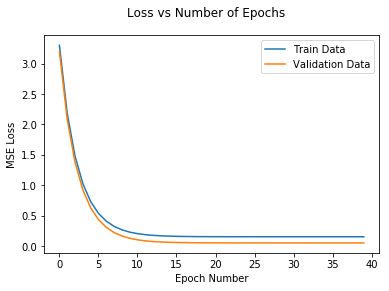

In [412]:
model.plot_loss()

In [413]:
min_validation = model.update_best_model()

In [414]:
print(min_validation)

0.05124468853004354


In [415]:
test_error = model.calculate_test_loss(test_data)

In [416]:
print(test_error)

0.022669172114239033


In [417]:
P = model.embedding_vars['P']
V = model.embedding_vars['V']
feedback_matrix = P @ V.T
norm = np.linalg.norm(feedback_matrix,ord='fro')
print('Norm: ' + str(norm))

Norm: 23.291219413720786


In [418]:
model.user_base_rank(movie_database,1,5,'cos')

,movieId,title,cos score
5680,27705,Lemony Snicket's A Series of Unfortunate Event...,0.02
7107,70686,Paper Heart (2009),0.02
7043,69121,"Hangover, The (2009)",0.02
9133,146729,Lost in the Sun (2015),0.02
8108,100578,Universal Soldier: Day of Reckoning (2012),0.02


In [419]:
model.user_base_rank(movie_database,1,5,'dot')

,movieId,title,dot score
5680,27705,Lemony Snicket's A Series of Unfortunate Event...,0.02
7107,70686,Paper Heart (2009),0.02
7043,69121,"Hangover, The (2009)",0.02
9133,146729,Lost in the Sun (2015),0.02
8108,100578,Universal Soldier: Day of Reckoning (2012),0.02


In [420]:
model.movie_base_rank(movie_database,'Aladdin',measure='dot')

,movieId,title,dot score
6493,53142,Fay Grim (2006),6.50
9474,168611,Ghost in the Shell (2017),5.25
4026,5692,Saturday Night Fever (1977),5.21
1589,2130,Autumn Sonata (Höstsonaten) (1978),4.68
8877,134094,My Love (2006),4.66


In [421]:
model.movie_base_rank(movie_database,'Aladdin',measure='cos')

,movieId,title,cos score
4026,5692,Saturday Night Fever (1977),0.02
9474,168611,Ghost in the Shell (2017),0.02
6493,53142,Fay Grim (2006),0.02
8877,134094,My Love (2006),0.01
1589,2130,Autumn Sonata (Höstsonaten) (1978),0.01
